Consider the AKLT spin-1 Hamiltonian
$$
    H = \sum_{i=1}^{L-1} \vec{S}_{i} \cdot \vec{S}_{i+1} + \frac{1}{3} (\vec{S}_{i} \cdot \vec{S}_{i+1})^{2}
$$

with periodic boundary conditions, i.e. $L + 1 = 1$, and with the spin-1 operators
$$
\begin{align*}
    S^{x} & = \frac{1}{\sqrt{2}} \begin{pmatrix} 0 & 1 & 0 \\  1 & 0 & 1 \\  0 & 1 & 0 \end{pmatrix}
    &
    S^{y} & = \frac{1}{\sqrt{2} i} \begin{pmatrix} 0 & 1 & 0 \\  -1 & 0 & 1 \\  0 & -1 & 0 \end{pmatrix}
    &
    S^{z} & = \frac{1}{\sqrt{2}} \begin{pmatrix} 1 & 0 & 0 \\  0 & 0 & 0 \\  0 & 0 & -1 \end{pmatrix}
\end{align*}
\,.$$

The ground state is given by
$ \ket{\Psi_{0}} = \sum_{{s}} \mathrm{Tr}[M^{[1]s_{1}} M^{[1]s_{1}} ... M^{[L]s_{L}}] \ket{s_{1}s_{2}...s_{L}} \,.$

with the AKLT ground state tensors
$$
\begin{align*}
    M^{[n] +1} & = \sqrt{\frac{4}{3}}\begin{pmatrix} 0 & 0 \\ \frac{1}{\sqrt{2}} & 0 \end{pmatrix}
    &
    M^{[n] 0} & = \sqrt{\frac{4}{3}}\begin{pmatrix} \frac{1}{2} & 0 \\ 0 & -\frac{1}{2} \end{pmatrix}
    &
    M^{[n] -1} & = \sqrt{\frac{4}{3}}\begin{pmatrix} 0 & -\frac{1}{\sqrt{2}} \\ 0 & 0 \end{pmatrix}
\end{align*}
\,$$
for all $n\in\{1, ..., L\} \,.$

In the following we consider open boundary conditions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
Sx = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]]) / np.sqrt(2)
Sy = np.array([[0, 1, 0], [-1, 0, 1], [0, -1, 0]]) / np.sqrt(2) / 1.j
Sz = np.array([[1, 0, 0], [0, 0, 0], [0, 0, -1]])

In [3]:
# def construct_aklt(L: int):

#     M = np.zeros((2, 3, 2), dtype='float')
#     M[:, 0, :] = np.sqrt(2/3) * np.array([[0, 0], [1, 0]])
#     M[:, 1, :] = np.sqrt(1/3) * np.array([[1, 0], [0, -1]])
#     M[:, 2, :] = np.sqrt(2/3) * np.array([[0, -1], [0, 0]])
    
#     aklt_mps = [M for _ in range(L)]
    
#     return aklt_mps

def construct_mps_singlets(L):
    """construct 2L-2 pairs of singlets and single spin-ups on the edges"""
    spin_up = np.array([1, 0]).reshape(1, 2, 1)

    M_odd_up, M_odd_down = [[1/np.sqrt(2), 0]], [[0, -1/np.sqrt(2)]]    
    M_odd = np.swapaxes([M_odd_up, M_odd_down], 0, 1)

    M_even_up, M_even_down = [[0], [1]], [[1], [0]]
    M_even = np.swapaxes([M_even_up, M_even_down], 0, 1)

    mps = [spin_up] + [M_odd if n % 2 == 1 else M_even for n in range(1, 2*L - 1)] + [spin_up]
    return mps

def construct_P():
    P_plus = [[1, 0], [0, 0]]
    P_minus = [[0, 0], [0, 1]]
    P_zero = np.array([[0, 1], [1, 0]]) / np.sqrt(2)
    P = np.array([P_plus, P_zero, P_minus])
    return P

def construct_aklt(L):
    mps_singlets = construct_mps_singlets(L)
    P = construct_P()
    
    aklt = []
    for (M_even, M_odd) in zip(mps_singlets[::2], mps_singlets[1::2]):
        t = np.tensordot(M_even, P, axes=[1, 1]) # eL [j] eR, j [pL] pR
        t = np.tensordot(t, M_odd, axes=[3, 1]) # eL eR j [pR], oL [j] oR
        M = t.squeeze(axis=(1, 3)) # eL eR j oL oR -> eL j oR
        aklt.append(M)
    # P is non-unitary, normalization is necessary
    norm = inner_product(aklt, aklt)**(0.5)
    aklt = [M / norm**(1/L) for M in aklt]
    return aklt

def inner_product(mps_a: list, mps_b: list):
    L = len(mps_a)
    assert L == len(mps_b)

    t = np.tensordot(mps_b[0], mps_a[0].conj(), axes=[1, 1]) # vL [j] vR, vL* [j*] vR*
    t = t.squeeze(axis=(0, 2))  # vR vR*
    for n in range(1, L):
        t = np.tensordot(t, mps_b[n], axes=[0, 0]) # [vR] vR*, [vL] j vR
        t = np.tensordot(t, mps_a[n].conj(), axes=[[0, 1], [0, 1]]) # [vR*] [j] vR, [vL*] [j*] vR*
    return t.item()

Let's compute the energy density of the ground state by acting on it with the Hamiltonian.

In [4]:
def bond_expectation_values(mps, op1, op2):
    """Calculate bond expectation value of local operator of the form op1 x op2 at each bond.
    op1 acts on site i and op2 acts on site i+1

    Parameters
    ----------
    mps : list of np.Array[ndim=3]
        Normalized MPS to calculate the expectation values for. 

    op1, op2 :
        Spin-1 operators acting on two neighboring sites i and i+1, respectively.

    Returns
    ----------
    exp_vals : list
        Expectation values at each bond.
    """
    L = len(mps)
    exp_vals = list()
    for i in range(L-1):
        t1 = np.tensordot(mps[i], op1, axes=[1, 1])
        t2 = np.tensordot(mps[i+1], op2, axes=[1, 1])

        t1 = np.tensordot(t1, mps[i].conj(), axes=[[0, 2], [0, 1]])
        t2 = np.tensordot(t2, mps[i+1].conj(), axes=[[1, 2], [2, 1]])

        exp_val = np.tensordot(t1, t2, axes=[[0, 1], [0, 1]])
        exp_vals.append(exp_val)
    return np.array(exp_vals)

In [5]:
def energy_density(mps):
    L = len(mps)
    spin_ops = [Sx, Sy, Sz]
    E = 0
    for s in spin_ops:
        E += bond_expectation_values(mps, s, s).sum()
        for s_ in spin_ops:
            E += bond_expectation_values(mps, s@s_, s@s_).sum() / 3
        
    assert np.isclose(E.imag, 0)
    return (E / L).real

In [6]:
L = 30
aklt_mps = construct_aklt(L)
energy_density(aklt_mps)

-1.266666666666667

Let's compute the sring correlation function $C(i, j) = \langle S_{i}^{z} \,\, \prod_{i<k<j} e^{i \pi S_{k}^{z}} \,\, S_{j}^{z} \rangle$.

In [7]:
def string_correlations(mps, X, Y, Z, i): # op1, op2, op_inter
    c_list = list()

    # case j=i
    t = np.tensordot(X@Y, mps[i], [1, 1])  # i* [i], vL [i] vR
    c = np.tensordot(mps[i].conj(), t, [[0, 1, 2], [1, 0, 2]]) # [vL*] [i*] [vR*], [i*] [vL] [vR]
    c_list.append(c)

    # case j>i
    L = len(mps)
    if i < L - 1:
        t = np.tensordot(X, mps[i], [1, 1]) # i* [i], vL [i] vR
        t = np.tensordot(t, mps[i].conj(), [[0, 1], [1, 0]]) # [i*] [vL] vR, [vL*] [i*] vR*
        for j in range(i + 1, L):
            t = np.tensordot(t, mps[j], [0, 0]) # [vR] vR*, [vL] j vR
            t_copy = t.copy()
            t_copy = np.tensordot(t_copy, Y, [1, 1]) # vR* [j] vR, j* [j]
            c = np.tensordot(t_copy, mps[j].conj(), [[0, 1, 2], [0, 2, 1]]) # [vR*] [vR] [j*], [vL*] [j*] [vR*]
            c_list.append(c)
            del t_copy

            if j + 1 < L:
                t = np.tensordot(t, Z, axes=[1, 1]) # vR* [j] vR, j [k]
                t = np.tensordot(t, mps[j].conj(), [[0, 2], [0, 1]]) # [vR*] vR [j], [vL*] [j*] vR*
                
    return c_list

In [8]:
# def site_expectation_value(mps, op, i):
#     t = np.tensordot(mps[i], op, [1, 1]) # vL [i] vR, i [k]
#     return np.tensordot(t, mps[i].conj(), [[0, 1, 2], [0, 2, 1]]) # vL vR i, vL* i* vR*

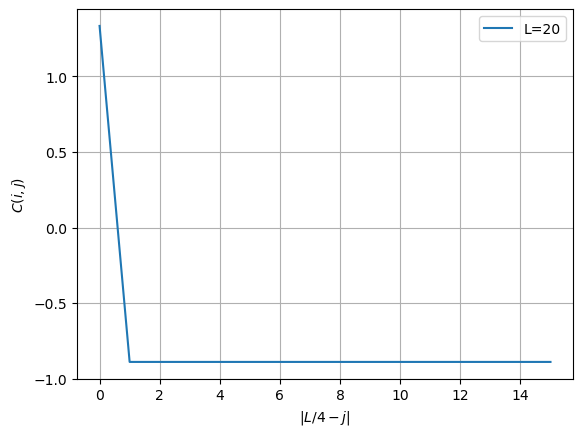

In [9]:
L = 20
aklt_mps = construct_aklt(L)
# string_corr = string_correlations(aklt_mps, Sz, Sz, np.exp(1.j*np.pi*Sz), L//4 - 1)
string_corr = string_correlations(aklt_mps, Sz, Sz, np.diag([-1, 1, -1]), L//4 - 1)

C = np.array(string_corr) #- np.array([ site_expectation_value(aklt_mps, Sz, L//4 - 1)*site_expectation_value(aklt_mps, Sz, j) for j in range(L//4 - 1, L) ])

fig, ax = plt.subplots(1, 1)
# ax.plot(string_corr, label="L={L:d}".format(L=len(aklt_mps)))
ax.plot(C, label="L={L:d}".format(L=len(aklt_mps)))
ax.set_xlabel("$|L/4 - j|$")
ax.set_ylabel("$C(i, j)$")
ax.legend()
ax.grid()

The string correlation does not vanish in the limit $L \to \infty$ and $|i - j| \to \infty$, indicating the presence of hidden order. In particular, $C(i, j) \to - 8/9$ (for $|i-j|\to\infty$). The literature value $-4/9$ refers to the case with periodic boundary condtions. Let's verify this case as well.

In [ ]:
def construct_aklt(L: int):
    M = np.zeros((2, 3, 2), dtype='float')
    M[:, 0, :] = np.sqrt(2/3) * np.array([[0, 0], [1, 0]])
    M[:, 1, :] = np.sqrt(1/3) * np.array([[1, 0], [0, -1]])
    M[:, 2, :] = np.sqrt(2/3) * np.array([[0, -1], [0, 0]])
    aklt_mps = [M for _ in range(L)]
    return aklt_mps


def string_correlations(mps, X, Y, Z, i, pbc=False): # op1, op2, op_inter
    c_list = list()

    # # case j=i
    # t = np.tensordot(X@Y, mps[i], [1, 1])  # i* [i], vL [i] vR
    # c = np.tensordot(mps[i].conj(), t, [[0, 1, 2], [1, 0, 2]]) # [vL*] [i*] [vR*], [i*] [vL] [vR]
    # c_list.append(c)

    # case j=i
    for l in range(i):
        t = np.tensordot(mps[l], mps[l].conj(), [1, 1])  # vL [i] vR, vL* [i*] vR*
        t = np.tensordot(t, mps[l+1], [[1, 3], [0, 1]]) # vL [vR] vL* vR*, [vL] i vR
        if l==i:
            t = np.tensordot(t, X@Y, [1, 1])  # vL vL* [i], i* [i]
    c = np.tensordot(mps[i].conj(), t, [[0, 1, 2], [1, 0, 2]]) # [vL*] [i*] [vR*], [i*] [vL] [vR]
    c_list.append(c)

    # case j>i
    L = len(mps)
    if i < L - 1:
        t = np.tensordot(X, mps[i], [1, 1]) # i* [i], vL [i] vR
        t = np.tensordot(t, mps[i].conj(), [[0, 1], [1, 0]]) # [i*] [vL] vR, [vL*] [i*] vR*
        for j in range(i + 1, L):
            t = np.tensordot(t, mps[j], [0, 0]) # [vR] vR*, [vL] j vR
            t_copy = t.copy()
            t_copy = np.tensordot(t_copy, Y, [1, 1]) # vR* [j] vR, j* [j]
            c = np.tensordot(t_copy, mps[j].conj(), [[0, 1, 2], [0, 2, 1]]) # [vR*] [vR] [j*], [vL*] [j*] [vR*]
            c_list.append(c)
            del t_copy
            if j + 1 < L:
                t = np.tensordot(t, Z, axes=[1, 1]) # vR* [j] vR, j [k]
                t = np.tensordot(t, mps[j].conj(), [[0, 2], [0, 1]]) # [vR*] vR [j], [vL*] [j*] vR*

    return c_list

In [ ]:
L = 20
aklt_mps = construct_aklt(L)
# string_corr = string_correlations(aklt_mps, Sz, Sz, np.exp(1.j*np.pi*Sz), L//4 - 1)
string_corr = string_correlations(aklt_mps, Sz, Sz, np.diag([-1, 1, -1]), L//4 - 1)

C = np.array(string_corr) #- np.array([ site_expectation_value(aklt_mps, Sz, L//4 - 1)*site_expectation_value(aklt_mps, Sz, j) for j in range(L//4 - 1, L) ])

fig, ax = plt.subplots(1, 1)
# ax.plot(string_corr, label="L={L:d}".format(L=len(aklt_mps)))
ax.plot(C, label="L={L:d}".format(L=len(aklt_mps)))
ax.set_xlabel("$|L/4 - j|$")
ax.set_ylabel("$C(i, j)$")
ax.legend()
ax.grid()